<a id="top"></a>
# Table of contents

#### 1. [Package instalation (optional)](#1)
#### 2. [Data loading](#2)
#### 3. [Feature Engineering](#3)
- ##### 3.1. [Outline](#3_1)
- ##### 3.2. [Tokenization](#3_2)
- ##### 3.3. [Basic word- and sentence-level metrics](#3_3)
- ##### 3.4. [Subjectivity and Polarity metrics](#3_4)
- ##### 3.5. [Cosine subjectivity between prompt_text and summary](#3_5)
- ##### 3.6. [Readability score](#3_6)
- ##### 3.7. [Misspelling frequency](#3_7)
- ##### 3.8. [Topic overlap](#3_8)
- - ##### 3.8.1 [Stopword filtering](#3_8_1)
- - ##### 3.8.2 [Lemmatization](#3_8_2)

<a id="1"></a>
## 1. Package installation

In [15]:
#pip install transformers sentence-transformers

  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/c1/bd/f64d67df4d3b05a460f281defe830ffab6d7940b7ca98ec085e94e024781/transformers-4.34.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 kB 2.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/5e/5d/97afbafd9d584ff1b45fcb354a479a3609bd97f912f8f1f6c563cb1fae21/filelock-3.12.4-py3-none-any.whl.metadata
  Obtaining dependency information for huggingface-hub<1.0,>=0.16.4 from https://files.pythonhosted.org/packages/ef/b5/b6107bd65fa4c96fdf00e4733e2fe5729bb9e5e09997f63074bb43d3ab28/huggingface_hub-0.18.0-py3-none-any.whl.metadata
  Obtaining dependency information for pyyaml>=5.1 from https://files.pythonhosted.org/packages/ec/0d/26fb23e8863e0aeaac0c64e03fd27367ad2ae3f3cccf37

<a id="2"></a>
## 2. Data loading

In [1]:
import pandas as pd
from IPython.display import display

In [2]:
summaries_train_df = pd.read_csv('../data/summaries_train.csv')
prompts_train_df = pd.read_csv('../data/prompts_train.csv')

In [3]:
#join the two data frames based on a unique key and drop unnecessary columns
joined_df = pd.merge(prompts_train_df, summaries_train_df, on = 'prompt_id')
joined_df.drop(['prompt_id', 'student_id'], axis = 1, inplace = True)

#rename 'text' column to 'summary'
joined_df.rename(columns = {'text' : 'summary'}, inplace=True)

joined_df.head(3)

,prompt_question,prompt_title,prompt_text,summary,content,wording
0,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415
1,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058
2,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181


<a id='3'></a>
## 3. Feature Engineering

<a id='3_1'></a>
### 3.1. Outline

The final goal is to train the model to predict content and wording scores.

• Wording Model  

a) Voice

Voice in writing refers to the author's distinctive style and tone. In the context of grading student summaries, "using objective language" means that the summary should avoid personal opinions, emotional language, or subjective statements. It should be neutral and objective, presenting the facts from the source text without adding the author's own perspective.  

b) Paraphrase  

Paraphrasing involves restating the information from the source text in a new way, without changing its meaning. A high score in paraphrasing means that the summary effectively conveys the key points of the source text in a concise and clear manner. It should avoid direct copying of sentences from the source.

c) Language  

This component assesses the quality of the language used in the summary. It considers factors such as vocabulary choice, sentence structure, and grammar. A good summary should use appropriate and varied vocabulary, follow correct grammar rules, and have coherent sentence structure.  

• Content Scores: 

a) Main idea  

This aspect evaluates how well the summary captures the primary message or main idea of the source text. A high score means that the summary effectively identifies and conveys the central theme or argument of the source.  

b) Details  

Details refer to specific information, examples, or evidence from the source text. A good summary should accurately represent these details without omitting crucial information or including irrelevant details. The summary should focus on the most relevant supporting details.  

c) Cohesion  

Cohesion assesses how well the summary transitions from one idea to the next. It considers the flow of the summary and how well sentences and paragraphs are connected. A high score indicates that the summary has a logical and smooth progression of ideas.


Some features that could be useful:  

• Extract average sentence length, average word length, word count, unique and stopwords percentage from prompt_text and summary and divide to create new feature.  

• For each summary calculate subjectivity and emotional tone (polarity).  

• Calculate cosine similarity between prompt_text and summary.  

• Calculate readability score. 

• Calculate frequency of misspelled words in student summaries.   

• Extract topics from prompt_text, prompt_question and student summaries. Use overlap as a feature.  

• Calculate most used 2-grams and 3-grams in prompt_text and summaries and calculate overlap in the 2 categories. Use this as a new feature. 

• Perform Named Entity Recognition (NER) on prompt_text and summaries, and calculate overlap to access if relevant features are captured.  

• Calculate the frequency of transition words in summaries to evaluate cohesion.  

###### [Go to top](#top)

<a id='3_2'></a>
### 3.2. Tokenization

In [4]:
import nltk
from nltk.tokenize import word_tokenize

# Download the 'punkt' resource
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/duje/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
joined_df['prompt_question_tokenized'] = joined_df['prompt_question'].apply(word_tokenize)
joined_df['prompt_title_tokenized'] = joined_df['prompt_title'].apply(word_tokenize)
joined_df['prompt_text_tokenized'] = joined_df['prompt_text'].apply(word_tokenize)
joined_df['summary_tokenized'] = joined_df['summary'].apply(word_tokenize)

joined_df.head(3)

,prompt_question,prompt_title,prompt_text,summary,content,wording,prompt_question_tokenized,prompt_title_tokenized,prompt_text_tokenized,summary_tokenized
0,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415,"[Summarize, at, least, 3, elements, of, an, id...","[On, Tragedy]","[Chapter, 13, As, the, sequel, to, what, has, ...","[1, element, of, an, ideal, tragedy, is, that,..."
1,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058,"[Summarize, at, least, 3, elements, of, an, id...","[On, Tragedy]","[Chapter, 13, As, the, sequel, to, what, has, ...","[The, three, elements, of, an, ideal, tragedy,..."
2,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181,"[Summarize, at, least, 3, elements, of, an, id...","[On, Tragedy]","[Chapter, 13, As, the, sequel, to, what, has, ...","[Aristotle, states, that, an, ideal, tragedy, ..."


###### [Go to top](#top)

<a id='3_3'></a>
### 3.3. Basic word- and sentence-level metrics

In [6]:
from nltk.tokenize import sent_tokenize

from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

In [7]:
def count_sentences(text):
    
    sentences = sent_tokenize(text)
    sentence_count = len(sentences)
    
    return sentence_count

def count_total_words(text):
    
    words = word_tokenize(text)
    
    special_characters = [".", ",", "!", "?", ":", ";", "'", '"', "(", ")", "[", "]", "{", "}"]
    words = [word for word in words if word not in special_characters]
    word_count = len(words)
    
    return word_count

def get_unique_words_percentage(text):
    
    words = word_tokenize(text)
    
    special_characters = [".", ",", "!", "?", ":", ";", "'", '"', "(", ")", "[", "]", "{", "}"]
    words = [word for word in words if word not in special_characters]
    unique_words = set(words)
    unique_word_count = len(unique_words)
    
    unique_word_percentage = unique_word_count / len(words)
    
    return unique_word_percentage    
    
def get_stopwords_percentage(text):
    
    words = word_tokenize(text)
    stopwords = [word for word in words if word not in stop and word.isalnum()]

    special_characters = [".", ",", "!", "?", ":", ";", "'", '"', "(", ")", "[", "]", "{", "}"]
    words = [word for word in words if word not in special_characters]
    
    stopwords_percentage = len(stopwords) / len(words)
    
    return stopwords_percentage
    
    

In [8]:
#sentence count
joined_df['prompt_text_sentence_count'] = joined_df['prompt_text'].apply(count_sentences)
joined_df['summary_sentence_count'] = joined_df['summary'].apply(count_sentences)
joined_df['sentence_count_ratio'] = joined_df['summary_sentence_count'] / joined_df['prompt_text_sentence_count']

#word count
joined_df['prompt_text_word_count'] = joined_df['prompt_text'].apply(count_total_words)
joined_df['summary_word_count'] = joined_df['summary'].apply(count_total_words)
joined_df['word_count_ratio'] = joined_df['summary_word_count'] / joined_df['prompt_text_word_count']

#average sentence length
joined_df['prompt_text_avg_sentence_length'] = joined_df['prompt_text_word_count'] / joined_df['prompt_text_sentence_count']
joined_df['summary_avg_sentence_length'] = joined_df['summary_word_count'] / joined_df['summary_sentence_count']
joined_df['avg_sentence_length_ratio'] = joined_df['summary_avg_sentence_length'] / joined_df['prompt_text_avg_sentence_length']

#percentage of unique words
joined_df['prompt_text_unique_words_percentage'] = joined_df['prompt_text'].apply(get_unique_words_percentage)
joined_df['summary_unique_words_percentage'] = joined_df['summary'].apply(get_unique_words_percentage)
joined_df['unique_words_percentage_ratio'] = joined_df['summary_unique_words_percentage'] / joined_df['prompt_text_unique_words_percentage']

#percentage of stopwords
joined_df['prompt_text_stopwords_percentage'] = joined_df['prompt_text'].apply(get_stopwords_percentage)
joined_df['summary_stopwords_percentage'] = joined_df['summary'].apply(get_stopwords_percentage)
joined_df['stopwords_percentage_ratio'] = joined_df['summary_stopwords_percentage'] / joined_df['prompt_text_stopwords_percentage']

In [9]:
joined_df.sample(3)

,prompt_question,prompt_title,prompt_text,summary,content,wording,prompt_question_tokenized,prompt_title_tokenized,prompt_text_tokenized,summary_tokenized,...,word_count_ratio,prompt_text_avg_sentence_length,summary_avg_sentence_length,avg_sentence_length_ratio,prompt_text_unique_words_percentage,summary_unique_words_percentage,unique_words_percentage_ratio,prompt_text_stopwords_percentage,summary_stopwords_percentage,stopwords_percentage_ratio
5417,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",The factories would use many different methods...,2.141224,1.123777,"[Summarize, the, various, ways, the, factory, ...","[Excerpt, from, The, Jungle]","[With, one, member, trimming, beef, in, a, can...","[The, factories, would, use, many, different, ...",...,0.188199,42.73913,18.500000,0.432859,0.397762,0.567568,1.426903,0.457782,0.535135,1.168973
6375,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...","Meats that are not good get recycled, based on...",-1.216579,0.011840,"[Summarize, the, various, ways, the, factory, ...","[Excerpt, from, The, Jungle]","[With, one, member, trimming, beef, in, a, can...","[Meats, that, are, not, good, get, recycled, ,...",...,0.041709,42.73913,41.000000,0.959308,0.397762,0.829268,2.084836,0.457782,0.463415,1.012304
562,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,3 elements of an ideal tragedy described by Ar...,-0.157460,-0.165811,"[Summarize, at, least, 3, elements, of, an, id...","[On, Tragedy]","[Chapter, 13, As, the, sequel, to, what, has, ...","[3, elements, of, an, ideal, tragedy, describe...",...,0.071192,24.16000,14.333333,0.593267,0.453642,0.744186,1.640469,0.495033,0.558140,1.127479


###### [Go to top](#top)

<a id='3_4'></a>
### 3.4. Subjectivity and Polarity metrics

In [12]:
from textblob import TextBlob

def polarity(text):
    return TextBlob(text).sentiment.polarity

def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [14]:
joined_df['prompt_text_polarity_score'] = joined_df['prompt_text'].apply(lambda x: polarity(x))
joined_df['summary_polarity_score'] = joined_df['summary'].apply(lambda x: polarity(x))
joined_df['polarity_score_ratio'] = joined_df['summary_polarity_score'] / joined_df['prompt_text_polarity_score']

joined_df['prompt_text_subjectivity_score'] = joined_df['prompt_text'].apply(lambda x: subjectivity(x))
joined_df['summary_subjectivity_score'] = joined_df['summary'].apply(lambda x: subjectivity(x))
joined_df['subjectivity_score_ratio'] = joined_df['summary_subjectivity_score'] / joined_df['prompt_text_subjectivity_score']

joined_df.sample(3)

,prompt_question,prompt_title,prompt_text,summary,content,wording,prompt_question_tokenized,prompt_title_tokenized,prompt_text_tokenized,summary_tokenized,...,prompt_question_non_stopwords,prompt_title_non_stopwords,prompt_text_non_stopwords,summary_non_stopwords,prompt_text_polarity_score,summary_polarity_score,polarity_score_ratio,prompt_text_subjectivity_score,summary_subjectivity_score,subjectivity_score_ratio
173,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,An ideal element for a tragedy is that the fal...,1.444398,1.889954,"[Summarize, at, least, 3, elements, of, an, id...","[On, Tragedy]","[Chapter, 13, As, the, sequel, to, what, has, ...","[An, ideal, element, for, a, tragedy, is, that...",...,"[Summarize, least, 3, elements, ideal, tragedy...","[On, Tragedy]","[Chapter, 13, As, sequel, already, said, must,...","[An, ideal, element, tragedy, fall, antagonist...",0.011411,0.274242,24.032493,0.491573,0.665152,1.353107
692,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,The first element of a ideal tragedy should no...,-0.472653,-0.005224,"[Summarize, at, least, 3, elements, of, an, id...","[On, Tragedy]","[Chapter, 13, As, the, sequel, to, what, has, ...","[The, first, element, of, a, ideal, tragedy, s...",...,"[Summarize, least, 3, elements, ideal, tragedy...","[On, Tragedy]","[Chapter, 13, As, sequel, already, said, must,...","[The, first, element, ideal, tragedy, simple, ...",0.011411,0.034416,3.015917,0.491573,0.404978,0.823841
3987,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,In the ancient times there where social classe...,-0.248808,0.383460,"[In, complete, sentences, ,, summarize, the, s...","[Egyptian, Social, Structure]","[Egyptian, society, was, structured, like, a, ...","[In, the, ancient, times, there, where, social...",...,"[In, complete, sentences, summarize, structure...","[Egyptian, Social, Structure]","[Egyptian, society, structured, like, pyramid,...","[In, ancient, times, social, classes, power, f...",0.206463,0.069444,0.336354,0.494048,0.343056,0.694378


###### [Go to top](#top)

<a id='3_5'></a>
### 3.5. Cosine similarity between prompt_text and summary

We will use pre-trained SBERT model to perform prompt_text and summary embeddings. Then, we calculate cosine similarity between the two.

In [23]:
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sentence_transformers import util

In [22]:
model_name = "sentence-transformers/paraphrase-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
sbert_model = SentenceTransformer(model_name)

In [43]:
def calculate_cosine_similarity(promp_text, summary):
    
    prompt_text_embedding = sbert_model.encode(promp_text, convert_to_tensor=True)
    summary_embedding = sbert_model.encode(summary, convert_to_tensor=True)
    similarity = util.pytorch_cos_sim(summary_embedding, prompt_text_embedding)
    
    return similarity.item()

In [44]:
joined_df['cosine_similarity'] = joined_df.apply(lambda x: calculate_cosine_similarity(x['prompt_text'], x['summary']), axis=1)

In [57]:
joined_df.sample(3)

,prompt_question,prompt_title,prompt_text,summary,content,wording,prompt_question_tokenized,prompt_title_tokenized,prompt_text_tokenized,summary_tokenized,...,prompt_title_non_stopwords,prompt_text_non_stopwords,summary_non_stopwords,prompt_text_polarity_score,summary_polarity_score,polarity_score_ratio,prompt_text_subjectivity_score,summary_subjectivity_score,subjectivity_score_ratio,cosine_similarity
2234,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,Egyptian society was structured like a pyramid...,-0.382272,-1.795491,"[In, complete, sentences, ,, summarize, the, s...","[Egyptian, Social, Structure]","[Egyptian, society, was, structured, like, a, ...","[Egyptian, society, was, structured, like, a, ...",...,"[Egyptian, Social, Structure]","[Egyptian, society, structured, like, pyramid,...","[Egyptian, society, structured, like, pyramid,...",0.206463,0.187500,0.908155,0.494048,0.625000,1.265060,0.654470
3957,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,Different social classes were involved the go...,-0.393310,0.627128,"[In, complete, sentences, ,, summarize, the, s...","[Egyptian, Social, Structure]","[Egyptian, society, was, structured, like, a, ...","[Different, social, classes, were, involved, t...",...,"[Egyptian, Social, Structure]","[Egyptian, society, structured, like, pyramid,...","[Different, social, classes, involved, governm...",0.206463,0.307222,1.488029,0.494048,0.534444,1.081767,0.335529
2371,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,So every one was in this goverment giving the ...,-1.264214,-1.505073,"[In, complete, sentences, ,, summarize, the, s...","[Egyptian, Social, Structure]","[Egyptian, society, was, structured, like, a, ...","[So, every, one, was, in, this, goverment, giv...",...,"[Egyptian, Social, Structure]","[Egyptian, society, structured, like, pyramid,...","[So, every, one, goverment, giving, gods, sacr...",0.206463,-0.350000,-1.695222,0.494048,0.900000,1.821687,0.417759


Text(0, 0.5, 'Frequency')

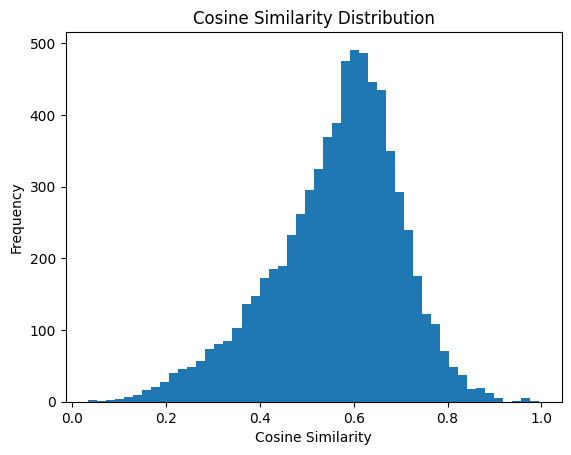

In [55]:
import matplotlib.pyplot as plt

joined_df['cosine_similarity'].hist(bins=50, grid=False)
plt.title('Cosine Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

###### [Go to top](#top)

<a id='3_6'></a>
### 3.6. Readability score

In [58]:
from textstat import flesch_reading_ease

In [60]:
joined_df['prompt_question_readability_score'] = joined_df['prompt_question'].apply(lambda x: flesch_reading_ease(x))
joined_df['summary_readability_score'] = joined_df['summary'].apply(lambda x: flesch_reading_ease(x))
joined_df['readability_score_ratio'] = joined_df['summary_readability_score'] / joined_df['prompt_question_readability_score']

joined_df.sample(3)

,prompt_question,prompt_title,prompt_text,summary,content,wording,prompt_question_tokenized,prompt_title_tokenized,prompt_text_tokenized,summary_tokenized,...,prompt_text_polarity_score,summary_polarity_score,polarity_score_ratio,prompt_text_subjectivity_score,summary_subjectivity_score,subjectivity_score_ratio,cosine_similarity,prompt_question_readability_score,summary_readability_score,readability_score_ratio
1918,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,You must have a good plot not one that makes t...,0.376374,0.463619,"[Summarize, at, least, 3, elements, of, an, id...","[On, Tragedy]","[Chapter, 13, As, the, sequel, to, what, has, ...","[You, must, have, a, good, plot, not, one, tha...",...,0.011411,0.388148,34.014313,0.491573,0.467407,0.950839,0.507538,58.28,70.77,1.214310
4204,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,The Third Wave developed quickly over a short ...,1.044649,0.958534,"[Summarize, how, the, Third, Wave, developed, ...","[The, Third, Wave]","[Background, The, Third, Wave, experiment, too...","[The, Third, Wave, developed, quickly, over, a...",...,-0.004218,0.034226,-8.115043,0.359906,0.348115,0.967238,0.560570,60.65,68.50,1.129431
3443,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,At the top of social class were the gods that ...,-0.093814,0.503833,"[In, complete, sentences, ,, summarize, the, s...","[Egyptian, Social, Structure]","[Egyptian, society, was, structured, like, a, ...","[At, the, top, of, social, class, were, the, g...",...,0.206463,0.266667,1.291598,0.494048,0.283333,0.573494,0.450743,53.88,87.92,1.631774


###### [Go to top](#top)

<a id='3_7'></a>
### 3.7. Misspelling frequency

In [61]:
from spellchecker import SpellChecker
sc = SpellChecker()

In [62]:
def calculate_misspeling_percentage(word_list):

    misspelled = sc.unknown(word_list)
    percentage_of_misspelled = len(misspelled)/len(word_list)
    
    return percentage_of_misspelled

In [65]:
joined_df['summary_misspelled_words_percentage'] = joined_df['summary_tokenized'].apply(lambda x: calculate_misspeling_percentage(x))

In [66]:
joined_df.sample(3)

,prompt_question,prompt_title,prompt_text,summary,content,wording,prompt_question_tokenized,prompt_title_tokenized,prompt_text_tokenized,summary_tokenized,...,summary_polarity_score,polarity_score_ratio,prompt_text_subjectivity_score,summary_subjectivity_score,subjectivity_score_ratio,cosine_similarity,prompt_question_readability_score,summary_readability_score,readability_score_ratio,summary_misspelled_words_percentage
3226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,The different social classes had their duties....,0.798306,1.387432,"[In, complete, sentences, ,, summarize, the, s...","[Egyptian, Social, Structure]","[Egyptian, society, was, structured, like, a, ...","[The, different, social, classes, had, their, ...",...,0.061458,0.297673,0.494048,0.466667,0.944578,0.425381,53.88,66.33,1.231069,0.028571
3916,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,in the text they have a goverment structure an...,0.003053,-1.256748,"[In, complete, sentences, ,, summarize, the, s...","[Egyptian, Social, Structure]","[Egyptian, society, was, structured, like, a, ...","[in, the, text, they, have, a, goverment, stru...",...,0.150000,0.726524,0.494048,0.500000,1.012048,0.799393,53.88,75.20,1.395694,0.027397
4769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,"After only three days, the experiment took on ...",-1.547163,-1.461245,"[Summarize, how, the, Third, Wave, developed, ...","[The, Third, Wave]","[Background, The, Third, Wave, experiment, too...","[After, only, three, days, ,, the, experiment,...",...,0.200000,-47.420079,0.359906,0.666667,1.852334,0.420729,60.65,72.16,1.189777,0.000000


###### [Go to top](#top)

<a id='3_8'></a>
### 3.8. Topic overlap

<a id='3_8_1'></a>
#### 3.8.1 Stopword filtering

In [67]:
def filter_stopwords(tokens):
    return [word for word in tokens if word not in stop and word.isalnum()]

In [68]:
joined_df['prompt_question_non_stopwords'] = joined_df['prompt_question_tokenized'].apply(filter_stopwords)
joined_df['prompt_title_non_stopwords'] = joined_df['prompt_title_tokenized'].apply(filter_stopwords)
joined_df['prompt_text_non_stopwords'] = joined_df['prompt_text_tokenized'].apply(filter_stopwords)
joined_df['summary_non_stopwords'] = joined_df['summary_tokenized'].apply(filter_stopwords)

<a id='3_8_2'></a>
#### 3.8.2 Lemmatization

In [87]:
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')
lem=WordNetLemmatizer()

from gensim import corpora
from gensim.models import LdaModel
import re

[nltk_data] Downloading package punkt to /Users/duje/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/duje/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [143]:
def calculate_topic_overlap(prompt_question, prompt_text, summary):
    
    num_topics = 3
    num_passes = 15
    num_words = 5
    
    #tokenize
    prompt_question_tokens = prompt_question.apply(lambda x: word_tokenize(x))
    prompt_text_tokens = prompt_text.apply(lambda x: word_tokenize(x))
    prompt_summary_tokens = summary.apply(lambda x: word_tokenize(x))
    
    #remove stopwords
    prompt_question_non_stopwords = prompt_question_tokens.apply(filter_stopwords)
    prompt_text_non_stopwords = prompt_text_tokens.apply(filter_stopwords)
    prompt_summary_non_stopwords = prompt_summary_tokens.apply(filter_stopwords)
    
    #remove special characters
    special_characters = [".", ",", "!", "?", ":", ";", "'", '"', "(", ")", "[", "]", "{", "}"]
    
    prompt_question_non_stopwords = prompt_question_non_stopwords.apply(lambda x: [word for word in x if word not in special_characters])
    prompt_text_non_stopwords = prompt_text_non_stopwords.apply(lambda x: [word for word in x if word not in special_characters])
    prompt_summary_non_stopwords = prompt_summary_non_stopwords.apply(lambda x: [word for word in x if word not in special_characters])    
    
    #lowercase
    prompt_question_non_stopwords = prompt_question_non_stopwords.apply(lambda x: [word.lower() for word in x])
    prompt_text_non_stopwords = prompt_text_non_stopwords.apply(lambda x: [word.lower() for word in x])
    prompt_summary_non_stopwords = prompt_summary_non_stopwords.apply(lambda x: [word.lower() for word in x])
    
    #flatten lists to create corpus
    prompt_combined = prompt_question_non_stopwords + prompt_text_non_stopwords
    corpus_prompt = [word for sublist in prompt_combined for word in sublist]
    corpus_summary = [word for sublist in prompt_summary_non_stopwords for word in sublist]
    
    #lemmatize and wrap in list for gensim (i.e. create list of lists as gensim expects)
    infinitives_prompt = [[lem.lemmatize(w) for w in corpus_prompt if len(w)>3]] # lemmatizing only words longer than 3 characters
    infinitives_summary = [[lem.lemmatize(w) for w in corpus_summary if len(w)>3]] # lemmatizing only words longer than 3 characters
    
    #create dictionary
    dictionary_prompt = corpora.Dictionary(infinitives_prompt)
    dictionary_summary = corpora.Dictionary(infinitives_summary)
    
    #create bag of words corpus
    bow_corpus_prompt = [dictionary_prompt.doc2bow(doc) for doc in infinitives_prompt]
    bow_corpus_summary = [dictionary_summary.doc2bow(doc) for doc in infinitives_summary]
    
    #create LDA model
    lda_model_prompt = LdaModel(bow_corpus_prompt, num_topics=num_topics, id2word=dictionary_prompt, passes=num_passes)
    lda_model_summary = LdaModel(bow_corpus_summary, num_topics=num_topics, id2word=dictionary_summary, passes=15)
    
    #get topics
    topics_prompt = lda_model_prompt.print_topics(num_words=num_words)
    topic_summary = lda_model_summary.print_topics(num_words=num_words)
    
    #get words describing topics and calculate cosine similarity between them
    topics_prompt_words = " ".join([" ".join(re.findall(r'"([^"]*)"', topic[1])) for topic in topics_prompt])
    topics_summary_words = " ".join([" ".join(re.findall(r'"([^"]*)"', topic[1])) for topic in topic_summary])
    
    topic_overlap = calculate_cosine_similarity(topics_prompt_words, topics_summary_words)
        
    return topics_prompt_words, topics_summary_words, topic_overlap

In [146]:
#joined_df['topics_prompt_words'], joined_df['topics_summary_words'], joined_df['topic_overlap'] = zip(*calculate_topic_overlap(joined_df['prompt_question'], joined_df['prompt_text'], joined_df['summary']))
